# Previous assignments

## Imports

In [1]:
# From source: https://keras.io/examples/keras_recipes/reproducibility_recipes/
import tensorflow as tf
import numpy as np

# Then Set Random Seeds
tf.keras.utils.set_random_seed(42)
tf.random.set_seed(42)
np.random.seed(42)

# Then run the Enable Deterministic Operations Function
tf.config.experimental.enable_op_determinism()

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler

In [3]:
## Load the autoreload extension
%load_ext autoreload 
%autoreload 2

import custom_functions as fn

## Dataset Prep

In [4]:
# Load Data from your path
df = pd.read_csv("Data/spooky.csv", index_col = 'id')
df.head()

,text,author
id,,
id26305,"This process, however, afforded me no means of...",EAP
id17569,It never once occurred to me that the fumbling...,HPL
id11008,"In his left hand was a gold snuff box, from wh...",EAP
id27763,How lovely is spring As we looked from Windsor...,MWS
id12958,"Finding nothing else, not even gold, the Super...",HPL


In [5]:
# Split on each space, and then get the length
df['sequence_length'] = df['text'].map( lambda x: len(x.split(" ")))
df['sequence_length'].describe()

count    19579.000000
mean        26.730477
std         19.048353
min          2.000000
25%         15.000000
50%         23.000000
75%         34.000000
max        861.000000
Name: sequence_length, dtype: float64

The range of sequence length is from 2 to 861 terms.

The average length is about 28 words.

In [6]:
# Use RUS to reduce n to match minority group
sampler = RandomUnderSampler(random_state=42)
df,  _ = sampler.fit_resample(df, df['author'])
df['author'].value_counts()

EAP    5635
HPL    5635
MWS    5635
Name: author, dtype: int64

In [7]:
## Define target and feature
# Crate a map for targets
target_map = {'EAP':0,
             'HPL':1,
             'MWS':2}
X = df['text'].values

y = df['author'].map(target_map)
classes = y.unique()
classes

array([0, 1, 2], dtype=int64)

In [8]:
# Convert to Dataset Object
ds = tf.data.Dataset.from_tensor_slices((X, y))

# Shuffle dataset
ds = ds.shuffle(buffer_size=len(ds),reshuffle_each_iteration=False) 

In [9]:
# Set the ratio of the train, validation, test split
split_train = .7
split_val =  .2
split_test =  1 -( split_train + split_val )

# Calculate the number of samples for training and validation data 
n_train_samples =  int(len(ds) * split_train)
n_val_samples = int(len(ds) * split_val)
n_test_samples = len(ds) -(n_train_samples + n_val_samples)

# Set the batch size
BATCH_SIZE =32


import math
# math.ceil will round up
n_train_batches = math.ceil(n_train_samples/BATCH_SIZE)
n_val_batches = math.ceil(n_val_samples/BATCH_SIZE)
n_test_batches = math.ceil(n_test_samples/BATCH_SIZE)

print(f"    - train:\t{n_train_samples} samples \t({n_train_batches} batches)")
print(f"    - val:  \t{n_val_samples} samples \t({n_val_batches} batches)")
print(f"    - test: \t{n_test_samples} samples \t({n_test_batches} batches)")

    - train:	11833 samples 	(370 batches)
    - val:  	3381 samples 	(106 batches)
    - test: 	1691 samples 	(53 batches)


In [10]:
# Use take and skip to define each set
train_ds = ds.take(n_train_samples).batch(batch_size=BATCH_SIZE)

# Skip over the training batches and take the validation batches
val_ds = ds.skip(n_train_samples).take(n_val_samples).batch(batch_size=BATCH_SIZE)

# Skipver the train and validation batches, the remaining are the test batches
test_ds = ds.skip(n_train_samples + n_val_samples).batch(batch_size=BATCH_SIZE)

In [11]:
# Confirm the number of batches in each
print (f' There are {len(train_ds)} training batches.')
print (f' There are {len(val_ds)} validation batches.')
print (f' There are {len(test_ds)} testing batches.')

 There are 370 training batches.
 There are 106 validation batches.
 There are 53 testing batches.


## Text Vectorization

In [12]:
SEQUENCE_LENGTH = 100
# Create text Vectorization layer
sequence_vectorizer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode="int",
    output_sequence_length=SEQUENCE_LENGTH
)

In [13]:
# Get just the text from ds_train
ds_texts = train_ds.map(lambda x, y: x)

In [14]:
# Train (adapt on training text data))
sequence_vectorizer.adapt(ds_texts)
sequence_vectorizer.vocabulary_size()

20976

In [15]:
# Programmatically define size of vocab from vectorization layer
VOCAB_SIZE = sequence_vectorizer.vocabulary_size()
VOCAB_SIZE

20976

In [16]:
# Getting list of vocab
vocab = sequence_vectorizer.get_vocabulary()
int_to_str = {idx: word for idx, word in enumerate(vocab)}

#### LSTM Model

In [17]:
# Define a function for building an LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers, regularizers
def build_lstm_model(text_vectorization_layer):
    
    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    lstm_model = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=150, 
                                  input_length=SEQUENCE_LENGTH)
        ])
        
    # Add LSTM layer
    lstm_model.add(layers.LSTM(128))
    # Add output layer
    lstm_model.add(layers.Dense(len(classes), activation='softmax'))
 
    # Compile the model
    lstm_model.compile(optimizer=optimizers.legacy.Adam(learning_rate = .01), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    lstm_model.summary()
    return lstm_model

In [18]:
# Include callbacks
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 100)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 100, 150)          3146400   
                                                                 
 lstm (LSTM)                 (None, 128)               142848    
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 3,289,635
Trainable params: 3,289,635
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
370/370 [==============================] - 31s 79ms/step - loss: 1.1042 - accuracy: 0.3269 - val_loss

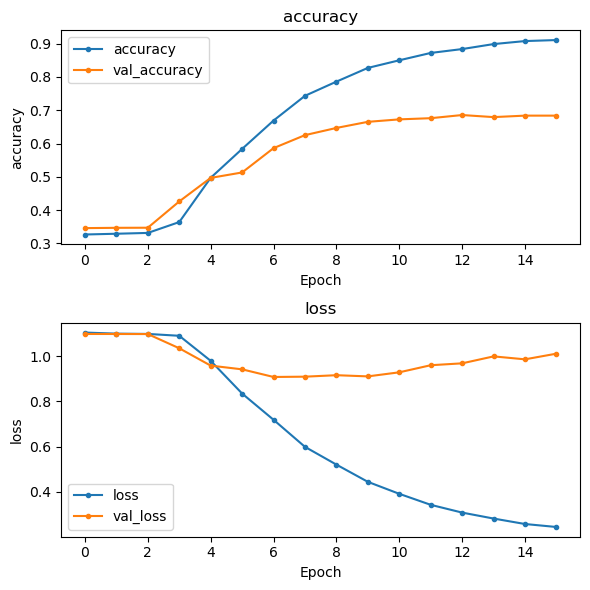


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      3906
           1       0.96      0.91      0.94      3952
           2       0.94      0.95      0.94      3975

    accuracy                           0.93     11833
   macro avg       0.93      0.93      0.93     11833
weighted avg       0.93      0.93      0.93     11833



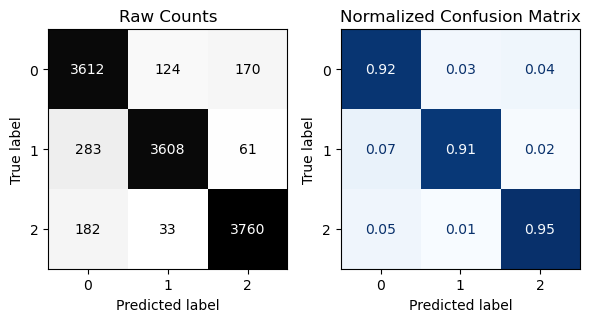


- Evaluating Training Data:
370/370 [==============================] - 8s 20ms/step - loss: 0.2085 - accuracy: 0.9279
{'loss': 0.2084985077381134, 'accuracy': 0.92791348695755}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.61      0.60      0.61       559
           1       0.72      0.69      0.70       560
           2       0.73      0.77      0.75       572

    accuracy                           0.69      1691
   macro avg       0.69      0.69      0.69      1691
weighted avg       0.69      0.69      0.69      1691



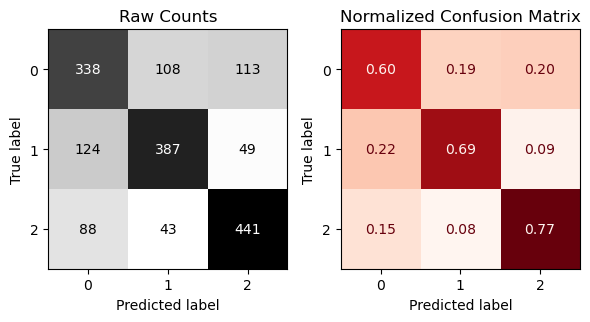


- Evaluating Test Data:
53/53 [==============================] - 1s 20ms/step - loss: 0.9847 - accuracy: 0.6895
{'loss': 0.9846780300140381, 'accuracy': 0.6895328164100647}


In [19]:
# Build the lstm model and specify the vectorizer
lstm_model = build_lstm_model(sequence_vectorizer)
# Defien number of epocs
EPOCHS = 30
# Fit the model
history = lstm_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)
# Obtain the results
results = fn.evaluate_classification_network(
    lstm_model, X_train=train_ds, 
    X_test=test_ds, history=history
);

#### GRU Model

In [20]:
def build_gru_model(text_vectorization_layer):
                
    gru_model = Sequential([
        text_vectorization_layer,
        tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, 
                                  output_dim=150, 
                                  input_length=SEQUENCE_LENGTH)])
    # Add GRU layer
    gru_model.add(layers.GRU(128, return_sequences = True))   
    gru_model.add(layers.GlobalMaxPooling1D())
    # Output layer
    gru_model.add(layers.Dense(len(classes), 
                              activation='softmax'))
        
    optimizer = optimizers.legacy.Adam()
    gru_model.compile(optimizer=optimizer,  
                      loss='sparse_categorical_crossentropy', 
                      metrics=['accuracy'])
    gru_model.summary()
    return gru_model

In [21]:
# Include callbacks
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 100)              0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 100, 150)          3146400   
                                                                 
 gru (GRU)                   (None, 100, 128)          107520    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 3,254,307
Trainable params: 3,254,307
No

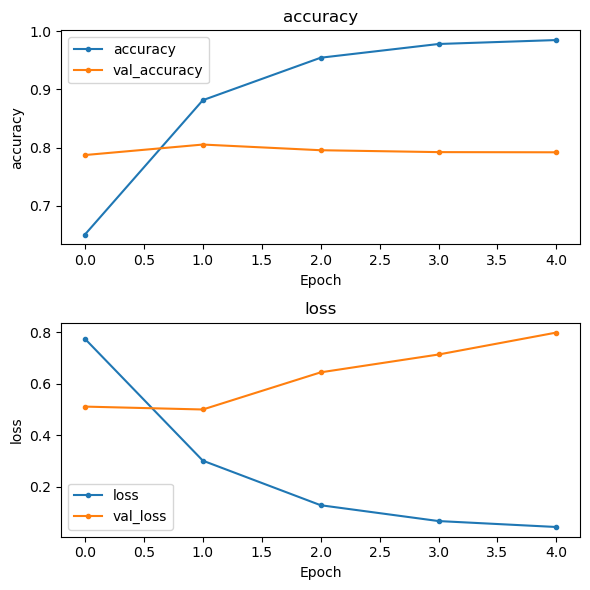


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3906
           1       1.00      1.00      1.00      3952
           2       1.00      0.99      0.99      3975

    accuracy                           1.00     11833
   macro avg       1.00      1.00      1.00     11833
weighted avg       1.00      1.00      1.00     11833



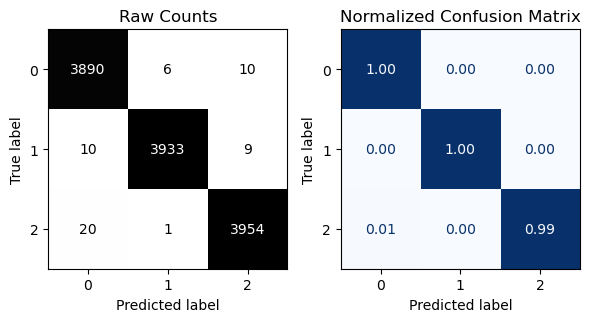


- Evaluating Training Data:
370/370 [==============================] - 6s 16ms/step - loss: 0.0184 - accuracy: 0.9953
{'loss': 0.01841754838824272, 'accuracy': 0.9952674508094788}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.77      0.79      0.78       559
           1       0.84      0.79      0.81       560
           2       0.81      0.83      0.82       572

    accuracy                           0.81      1691
   macro avg       0.81      0.81      0.81      1691
weighted avg       0.81      0.81      0.81      1691



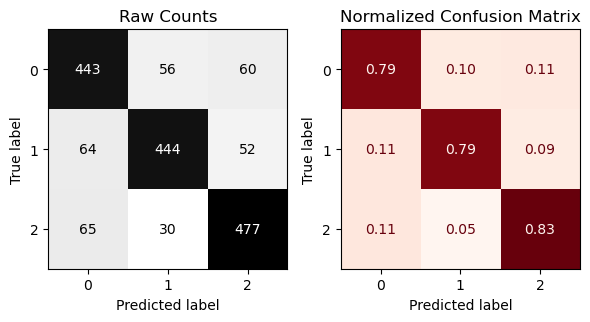


- Evaluating Test Data:
53/53 [==============================] - 1s 16ms/step - loss: 0.7521 - accuracy: 0.8066
{'loss': 0.752083957195282, 'accuracy': 0.8066232800483704}


In [22]:
# Build the model
model = build_gru_model(sequence_vectorizer)
# Fit the model
EPOCHS = 30
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)
# Evaluate the model
results = fn.evaluate_classification_network(
    model, X_train=train_ds, 
    X_test=test_ds, history=history);

# Text Classification with RNNs Core
**Studnet:** Matthew Malueg

**Task**

This assignment continues to use the dataset from the practice assignment and the first core assignment. This is the "spooky" dataset and represents passages from three famous authors: Edgar Allan Poe, HP Lovecraft, and Mary Shelley. The ultimate goal is a multi-class text classification matching each passage to the correct author.

**Now, try to improve the performance of the RNN model.**

You will build, fit, and evaluate at least 3 models using architecture or techniques you have learned in the course. Consider stacked RNNs, bi-directional RNNs, pre-trained word embeddings, pooling layers, dropout layers, and tuning of hyperparameters. Your goal should be to achieve the highest accuracy possible. An accuracy score above 80% is achievable.


### Model 1

Between our initial GRU and LSTM, the default GRU performed better, so we will start with that as a base model.

We will add additional GRU layers to the stack and implement dropout layers as well.

In [29]:
def build_gru_stacked_model(text_vectorization_layer):
    
    model = tf.keras.Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE, 
                         output_dim=150, 
                         input_length=SEQUENCE_LENGTH)])

    # Stack three GrU layers    
    model.add(layers.GRU(128, return_sequences=True))
    model.add(layers.Dropout(.5))
    model.add(layers.GRU(64, return_sequences=True))
    model.add(layers.Dropout(.5))
    model.add(layers.GRU(32, return_sequences = True)) 
    model.add(layers.GlobalMaxPooling1D())
    
    # Output layer
    model.add(layers.Dense(len(classes), activation='softmax'))
    
    # Compile
    optimizer = optimizers.legacy.Adam()
    model.compile(optimizer=optimizer,  
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    model.summary()
    return model

In [30]:
# Include callbacks
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]

In [31]:
# Build model
model = build_gru_stacked_model(sequence_vectorizer)

EPOCHS = 30
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 100)              0         
 torization)                                                     
                                                                 
 embedding_3 (Embedding)     (None, 100, 150)          3146400   
                                                                 
 gru_4 (GRU)                 (None, 100, 128)          107520    
                                                                 
 dropout_2 (Dropout)         (None, 100, 128)          0         
                                                                 
 gru_5 (GRU)                 (None, 100, 64)           37248     
                                                                 
 dropout_3 (Dropout)         (None, 100, 64)           0         
                                                      

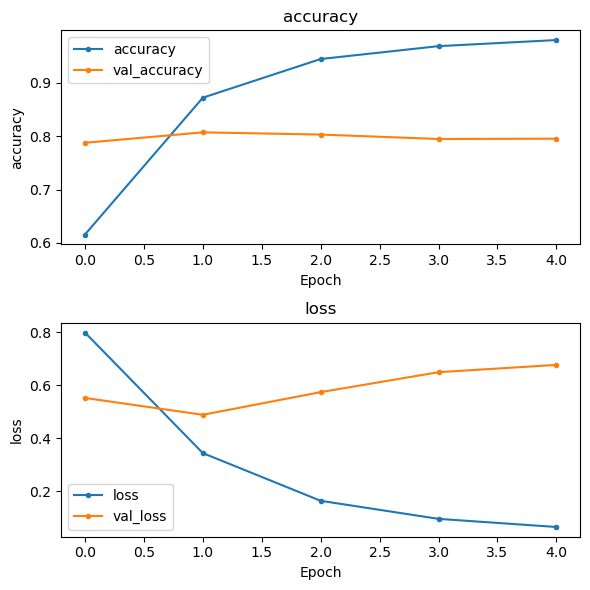


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3906
           1       1.00      0.98      0.99      3952
           2       0.99      0.99      0.99      3975

    accuracy                           0.99     11833
   macro avg       0.99      0.99      0.99     11833
weighted avg       0.99      0.99      0.99     11833



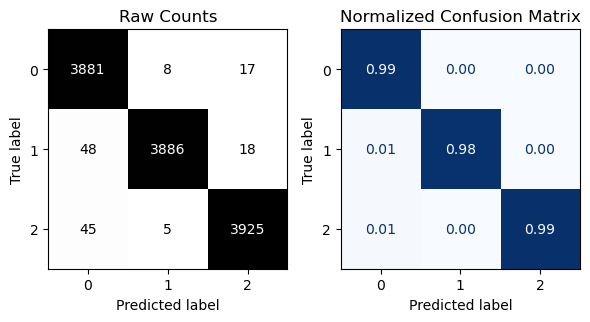


- Evaluating Training Data:
370/370 [==============================] - 10s 28ms/step - loss: 0.0414 - accuracy: 0.9881
{'loss': 0.04140515625476837, 'accuracy': 0.9880841970443726}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.76      0.82      0.79       559
           1       0.87      0.76      0.81       560
           2       0.80      0.84      0.82       572

    accuracy                           0.81      1691
   macro avg       0.81      0.81      0.81      1691
weighted avg       0.81      0.81      0.81      1691



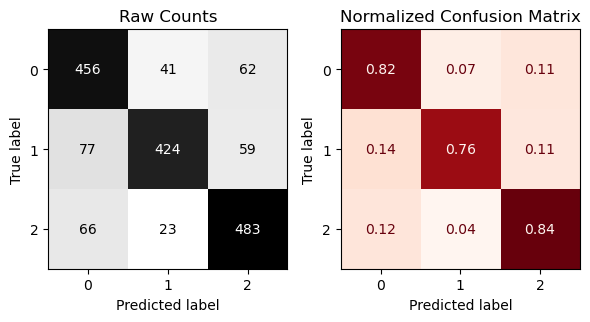


- Evaluating Test Data:
53/53 [==============================] - 2s 28ms/step - loss: 0.6698 - accuracy: 0.8060
{'loss': 0.6698456406593323, 'accuracy': 0.8060319423675537}


In [32]:
# Evaluate the model
results = fn.evaluate_classification_network(
    model, X_train=train_ds, X_test=test_ds, history=history);

The overall results are not significantly different than the default GRU model. Accuracy remained about the same, while the Loss dropped from around 0.75 to 0.67. Both the default and stacked models begin to show overfitting early on, so perhaps stopping earlier will help.

### Model 2

Try a model with fewer stacked layers, but include bidirectionality and stop earlier to try and address overfitting.

In [35]:
def build_bidir_GRU(text_vectorization_layer):
    
    model = tf.keras.Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE, 
                         output_dim=150, 
                         input_length=SEQUENCE_LENGTH)])

    # Stack two bidirectional GrU layers    
    model.add(layers.Bidirectional(layers.GRU(128, return_sequences=True)))
    model.add(layers.Dropout(.5))
    model.add(layers.Bidirectional(layers.GRU(64, return_sequences=True)))
    model.add(layers.Dropout(.5))
    model.add(layers.GlobalMaxPooling1D())
    
    # Output layer
    model.add(layers.Dense(len(classes), activation='softmax'))
    
    # Compile
    optimizer = optimizers.legacy.Adam()
    model.compile(optimizer=optimizer,  
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    model.summary()
    return model

In [36]:
# Include callbacks, stopping earlier
def get_callbacks(patience=2, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]

In [38]:
# Build model
model = build_bidir_GRU(sequence_vectorizer)

EPOCHS = 30
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 100)              0         
 torization)                                                     
                                                                 
 embedding_4 (Embedding)     (None, 100, 150)          3146400   
                                                                 
 bidirectional (Bidirectiona  (None, 100, 256)         215040    
 l)                                                              
                                                                 
 dropout_4 (Dropout)         (None, 100, 256)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 100, 128)         123648    
 nal)                                                            
                                                      

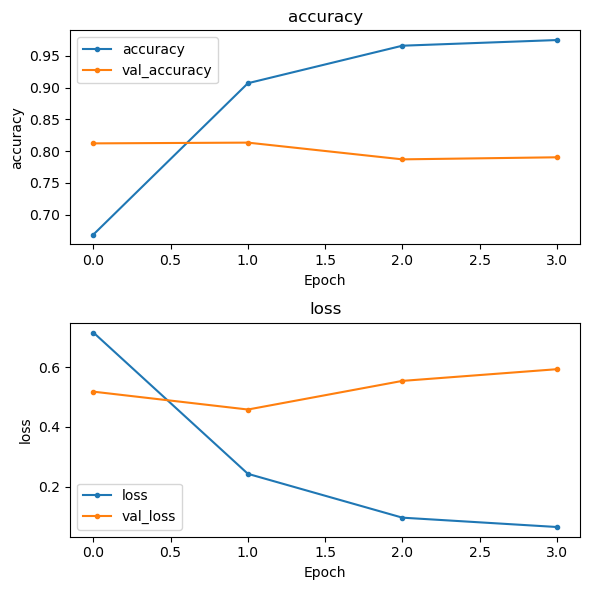


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3906
           1       1.00      0.98      0.99      3952
           2       0.99      0.99      0.99      3975

    accuracy                           0.99     11833
   macro avg       0.99      0.99      0.99     11833
weighted avg       0.99      0.99      0.99     11833



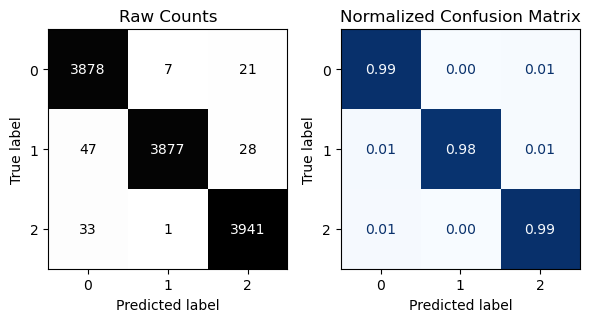


- Evaluating Training Data:
370/370 [==============================] - 11s 30ms/step - loss: 0.0548 - accuracy: 0.9884
{'loss': 0.05482582375407219, 'accuracy': 0.9884222149848938}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.74      0.81      0.77       559
           1       0.88      0.72      0.79       560
           2       0.79      0.85      0.82       572

    accuracy                           0.79      1691
   macro avg       0.80      0.79      0.79      1691
weighted avg       0.80      0.79      0.79      1691



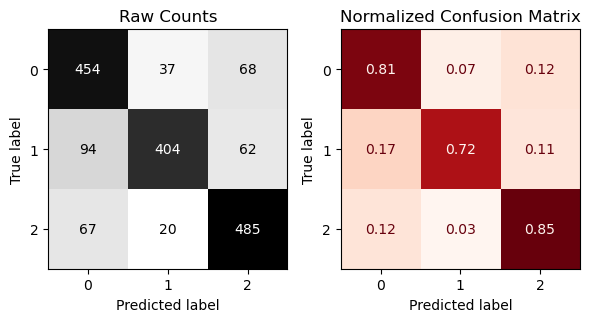


- Evaluating Test Data:
53/53 [==============================] - 2s 30ms/step - loss: 0.5674 - accuracy: 0.7942
{'loss': 0.5673648118972778, 'accuracy': 0.794204592704773}


In [39]:
# Evaluate the model
results = fn.evaluate_classification_network(
    model, X_train=train_ds, X_test=test_ds, history=history);

This model again had similar accuracy. However the loss is reduced again, from 0.75 in the default and 0.67 in Model 1, to 0.57 in Model 2. While training scores continue to improve over epochs, the validation scores remained level. We will try using a pre-trained embedding layer with this dataset.

### Model 3

Try including a pre-trained word embedding layer using the GloVe embeddings.

In [40]:
from gensim.models import KeyedVectors
# Load GloVe vectors into a gensim model
glove_model = KeyedVectors.load_word2vec_format("GloVe/glove.6B.100d.txt", binary=False, no_header=True)

In [42]:
vocab_size = len(sequence_vectorizer.get_vocabulary())  
embedding_dim = 100
# Initialize an empty matrix to hold the word embeddings
embedding_matrix = np.zeros((vocab_size, embedding_dim))

In [43]:
# Loop to get each word from vocabulary and get its pre-trained vector from GloVe model
for i, word in enumerate(sequence_vectorizer.get_vocabulary()):
    try:
        embedding_matrix[i] = glove_model[word]
    except KeyError:
        pass

In [45]:
# Create the embedding layer using the embedding matrix
from tensorflow.keras.layers import Embedding
initializer = tf.keras.initializers.Constant(embedding_matrix)
glove_embedding_layer = Embedding(input_dim=vocab_size, 
                                  output_dim=embedding_dim, 
                                  embeddings_initializer =initializer,
                                  trainable=False,
                                  input_length=SEQUENCE_LENGTH)

In [46]:
def build_glove_gru(text_vectorization_layer, glove_embedding_layer):
    
    model = tf.keras.Sequential([
        text_vectorization_layer, glove_embedding_layer])

    # Stack two bidirectional GrU layers    
    model.add(layers.Bidirectional(layers.GRU(128, return_sequences=True)))
    model.add(layers.Dropout(.5))
    model.add(layers.Bidirectional(layers.GRU(64, return_sequences=True)))
    model.add(layers.Dropout(.5))
    model.add(layers.GlobalMaxPooling1D())
    
    # Output layer
    model.add(layers.Dense(len(classes), activation='softmax'))
    
    # Compile
    optimizer = optimizers.legacy.Adam()
    model.compile(optimizer=optimizer,  
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    model.summary()
    return model

In [47]:
def get_callbacks(patience=2, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor, restore_best_weights=False)
    return [early_stop]

In [49]:
# Build, fit, evaluate
# Build the model
model = build_glove_gru(sequence_vectorizer,glove_embedding_layer)
EPOCHS = 30
# Fit the mdoel
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 100)              0         
 torization)                                                     
                                                                 
 embedding_6 (Embedding)     (None, 100, 100)          2097600   
                                                                 
 bidirectional_2 (Bidirectio  (None, 100, 256)         176640    
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 100, 256)          0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 100, 128)         123648    
 nal)                                                            
                                                      

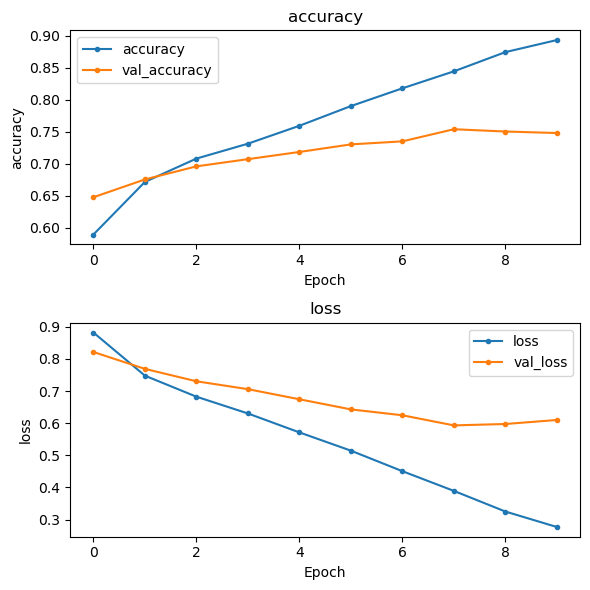


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      3906
           1       0.96      0.92      0.94      3952
           2       0.91      0.96      0.93      3975

    accuracy                           0.93     11833
   macro avg       0.93      0.93      0.93     11833
weighted avg       0.93      0.93      0.93     11833



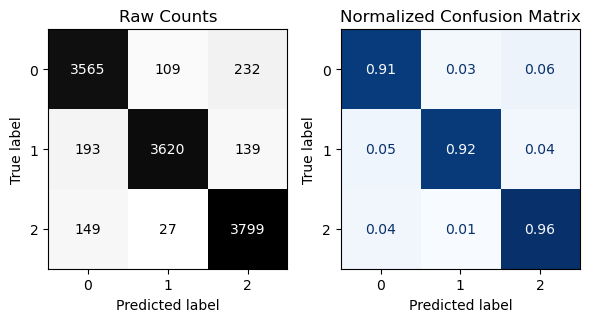


- Evaluating Training Data:
370/370 [==============================] - 11s 30ms/step - loss: 0.2570 - accuracy: 0.9283
{'loss': 0.25699135661125183, 'accuracy': 0.9282515048980713}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.69      0.70       559
           1       0.79      0.71      0.75       560
           2       0.74      0.83      0.78       572

    accuracy                           0.74      1691
   macro avg       0.75      0.74      0.74      1691
weighted avg       0.75      0.74      0.74      1691



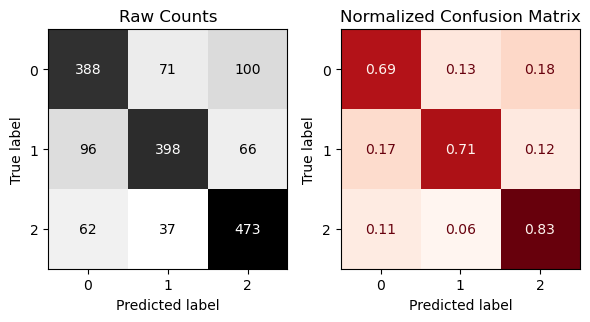


- Evaluating Test Data:
53/53 [==============================] - 2s 30ms/step - loss: 0.6218 - accuracy: 0.7445
{'loss': 0.6218111515045166, 'accuracy': 0.7445298433303833}


In [51]:
# Evaluate the mdoel
results = fn.evaluate_classification_network(
    model, X_train=train_ds, X_test=test_ds, history=history,);

This third model with pre-trained word embeddings did not perform as well. The best option so far is Model 2, with stacked bidirectional GRU layers.